In [361]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.linear_model as sk
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from random import randint
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelPropagation
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict,Counter

In [362]:
# data = pd.read_csv('../SPECT.train',header=None)     #label Column is 0
# label_col_name = 0

In [363]:
# data_df = pd.read_csv("../haberman.data",header=None)
# data_df.fillna(data_df.median(),inplace=True)
# data_df.columns = ['Age','Year','Nodes','Survival_status']
# data_df['Survival_status'] = data_df['Survival_status'].astype(int)
# data_df['Survival_status'] = data_df['Survival_status'].map({2:0 , 1:1})
# data_df.drop_duplicates(inplace=True)
# data = data_df
# label_col_name = 'Survival_status'

In [364]:
df = pd.read_csv('../heart-disease.data',header=None, names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','label'])
label = df['label']
df.replace(r'?',np.nan,inplace=True)
df.fillna(df.median(),inplace=True)
df_std = StandardScaler().fit_transform(df)
df = pd.DataFrame(df_std)
df.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','label']
df['label'] = label
df['label'] = df['label'].map({1:1,2:1,3:1,4:1,0:0})
data = df
label_col_name = 'label'

In [365]:
def model_accuracy(df,model,label):
    m = model()
    features = df.loc[:,df.columns!=label]
    label = df[label]
    x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.38)
    m.fit(x_train,y_train)
    return m.score(x_test,y_test)

In [366]:
models = [SVC,RandomForestClassifier,GaussianNB,LogisticRegression,DecisionTreeClassifier]
acc = pd.DataFrame()
for model in models:
    result = model_accuracy(data,model,label_col_name)
    acc = acc.append(pd.Series(model_accuracy(data,model,label_col_name)),ignore_index=True)
acc.columns = ['Accuracy']    
acc['model'] = pd.Series(["SVC","Random Forest","Naive Bayes","Logistic Regression","Decision Tree"])                     

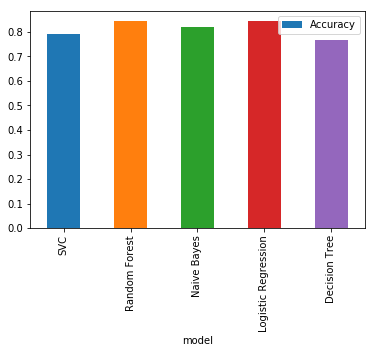

In [367]:
acc.plot(x='model',y='Accuracy',kind='bar')

> Adding Noise

In [368]:
data['Original_label'] = data[label_col_name]
class0 = data.loc[data[label_col_name]!=1,:]
class1 = data.loc[data[label_col_name]!=0,:]
def noise(data):
    sample = data.sample(frac = 0.3)
    for i in list(sample.index):
        data[label_col_name][i] = int(not data[label_col_name][i])
    return list(sample.index)
noise(class0)
noise(class1)
mislabeled = pd.concat([class0,class1])
mislabeled.reset_index(inplace=True)
indices = list(mislabeled.index)
noisey_indices = mislabeled[mislabeled['Original_label']!=mislabeled[label_col_name]].index
mislabeled.drop(columns=['index'],inplace=True)

> Ensemble Learning

In [369]:
features = mislabeled.loc[:,data.columns!=0]
label = mislabeled[label_col_name]
x_train,x_test,y_train,y_test = train_test_split(features,label,test_size = 0.38)

In [370]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
predict = lr.predict(features)
predicted = defaultdict(list)
for i in range(len(indices)):
    predicted[indices[i]].append(predict[i])    

In [371]:
svm = SVC()
svm.fit(x_train,y_train)
predict = svm.predict(features)
# predicted = defaultdict(list)
for i in range(len(indices)):
    predicted[indices[i]].append(predict[i])    

In [372]:
dt = GaussianNB()
dt.fit(x_train,y_train)
predict = dt.predict(features)
# predicted = defaultdict(list)
for i in range(len(indices)):
    predicted[indices[i]].append(predict[i])    

In [373]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
predict = dt.predict(features)
# predicted = defaultdict(list)
for i in range(len(indices)):
    predicted[indices[i]].append(predict[i])    

In [374]:
unlabel = {}
for row in predicted:
    if sum(predicted[row])>3:
        unlabel[row] = 1
    elif sum(predicted[row]) == 0:
        unlabel[row] = 0
    else:
        unlabel[row] = -1
unlabel = pd.DataFrame(list(unlabel.items()))
unlabel.set_index(0,inplace=True)
unlabel.columns = ['unlabeled']

In [375]:
mislabeled = mislabeled.join(unlabel)

In [379]:
def ApplySemiSupervised(mislabeled,col,original_mis_col):
    lp = LabelPropagation()
    lp.fit(mislabeled[mislabeled.columns.difference([col,'Original_label', original_mis_col])],mislabeled[col])
    arr = lp.predict(mislabeled[mislabeled.columns.difference([col,'Original_label',original_mis_col])])    
    mislabeled['semi'] = arr
    detected = []
    cnt = 0
    for i in indices:
        if mislabeled['Original_label'][i] != mislabeled['semi'][i]:
            detected.append(i)
    bad_change =  0
    #detected Noise (Comparing with mislabled Data label)
    for i in detected:
        if i in noisy_indices:
            cnt+=1
        else:
            bad_change+=1
                
    return pd.DataFrame(data={'Total Mislabeled':[len(noisy_indices)], 
                              'Total Mismatch':[len(detected)], 
                              'True Identified labels(Actual Noise)':[cnt], 
                              'False identified labels(Not Noise fliped)':[bad_change], 
                              'Total Noise Ratio':len(noisy_indices)/data.shape[0], 
                              'True Identified Ratio(Actual Noise detected ratio)':cnt/len(noisy_indices)}
                       )


In [381]:
ApplySemiSupervised(mislabeled,'unlabeled',label_col_name)


,Total Mislabeled,Total Mismatch,True Identified labels(Actual Noise),False identified labels(Not Noise fliped),Total Noise Ratio,True Identified Ratio(Actual Noise detected ratio)
0,91,89,31,58,0.30033,0.340659


In [378]:
mislabeled.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label,Original_label,unlabeled,semi
0,0.948726,0.686202,-2.251775,0.757525,-0.264900,2.394438,1.016684,0.017197,-0.696631,1.087338,2.274579,-0.711131,0.660004,0,0,0,0
1,-1.932564,0.686202,-0.165268,-0.096170,0.063974,-0.417635,-0.996749,1.637359,-0.696631,2.122573,2.274579,-0.711131,-0.890238,0,0,0,0
2,-1.489288,-1.457296,-1.208521,-0.096170,-0.825922,-0.417635,1.016684,0.980537,-0.696631,0.310912,-0.976352,-0.711131,-0.890238,0,0,0,0
3,0.172994,0.686202,-1.208521,-0.665300,-0.206864,-0.417635,-0.996749,1.243266,-0.696631,-0.206705,-0.976352,-0.711131,-0.890238,0,0,0,0
4,0.283813,-1.457296,0.877985,-0.665300,2.075914,-0.417635,-0.996749,0.586443,1.435481,-0.379244,-0.976352,-0.711131,-0.890238,1,0,1,1
